In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Generate data
n_samples = 20000
y = np.random.uniform(-.5, 2.5, n_samples)
X = y.reshape(-1, 1)
xtrue = np.zeros_like(y)

# Apply conditions to generate xtrue based on y
for i in range(len(xtrue)):
    if (0 < y[i] < 0.5) or (1.5 < y[i] < 2):
        xtrue[i] = np.random.normal(1, scale=0.5 )
    else:
        xtrue[i] = np.random.normal(-1, scale=0.5 )

# Generate x and s (noisy observations)
x = xtrue + np.random.normal(0, 1, len(xtrue))
 
# Standardize the input y
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define dataset class
class DensityRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Mixture Density Network
class MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_gaussians):
        super(MDN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.pi = nn.Linear(hidden_dim, n_gaussians)  # Mixing coefficients (weights)
        self.mu = nn.Linear(hidden_dim, n_gaussians)  # Means of Gaussians
        self.log_sigma = nn.Linear(hidden_dim, n_gaussians)  # Log of standard deviations

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        pi = torch.softmax(self.pi(x), dim=1)  # Softmax for mixture weights
        mu = self.mu(x)  # Mean of each Gaussian
        log_sigma = self.log_sigma(x)  # Log standard deviation for stability
        return pi, mu, log_sigma

# Negative log-likelihood loss for Mixture Density Networks
def mdn_loss(pi, mu, log_sigma, y):
    sigma = torch.exp(log_sigma)
    m = torch.distributions.Normal(mu, sigma)
    probs = m.log_prob(y.unsqueeze(1))  # Log probability of y under each Gaussian
    log_probs = probs + torch.log(pi + 1e-8)  # Log-prob weighted by pi
    nll = -torch.logsumexp(log_probs, dim=1)  # Logsumexp for numerical stability
    return nll.mean()

# Create dataset and dataloader
dataset = DensityRegressionDataset(X_scaled, x)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Initialize model, optimizer, and loss function
n_gaussians = 5  # Number of Gaussians in the mixture
model = MDN(input_dim=1, hidden_dim=64, n_gaussians=n_gaussians)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        pi, mu, log_sigma = model(inputs)
        loss = mdn_loss(pi, mu, log_sigma, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(dataloader):.4f}')

# Generate predictions for plotting

 


Epoch 10/200, Loss: 1.5702
Epoch 20/200, Loss: 1.5539
Epoch 30/200, Loss: 1.5493
Epoch 40/200, Loss: 1.5466
Epoch 50/200, Loss: 1.5452
Epoch 60/200, Loss: 1.5448
Epoch 70/200, Loss: 1.5428
Epoch 80/200, Loss: 1.5419
Epoch 90/200, Loss: 1.5422
Epoch 100/200, Loss: 1.5405
Epoch 110/200, Loss: 1.5403
Epoch 120/200, Loss: 1.5399
Epoch 130/200, Loss: 1.5397
Epoch 140/200, Loss: 1.5389
Epoch 150/200, Loss: 1.5385
Epoch 160/200, Loss: 1.5388
Epoch 170/200, Loss: 1.5386
Epoch 180/200, Loss: 1.5382
Epoch 190/200, Loss: 1.5394
Epoch 200/200, Loss: 1.5388


In [2]:
# Assuming your model has been trained and you have the dataset object

# Set model to evaluation mode
model.eval()

# Create a DataLoader for the entire training set (no shuffling)
train_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

# Get the fitted pi, mu, and log_sigma for the entire dataset
with torch.no_grad():
    for X_batch, _ in train_loader:  # Load entire dataset
        pi, mu, log_sigma = model(X_batch)

# Convert the tensors to numpy arrays
pi_np = pi.numpy()
mu_np = mu.numpy()
log_sigma_np = log_sigma.numpy()

# Concatenate pi, mu, and log_sigma into a single 2D array along axis 1
fitted_params = np.hstack((pi_np, mu_np, log_sigma_np))

# Check the shape of the resulting array and print first few rows
print(fitted_params.shape)
print(fitted_params[:5])  # First 5 rows as a preview


(20000, 15)
[[ 5.5358134e-04  1.7510999e-04  2.4248853e-02  3.9797933e-03
   9.7104263e-01 -1.5839040e-03  5.2651078e-01 -1.4315242e+00
   4.8155269e-01 -1.0252435e+00 -8.1418639e-01 -2.7106784e-02
  -1.9048077e+00 -1.5113946e+00  1.6813233e-01]
 [ 7.5828955e-02  9.0901417e-01  3.9899298e-03  1.0096540e-02
   1.0704825e-03  2.0892889e+00  8.7209707e-01  9.0270185e-01
   1.7855736e+00 -2.6222762e-01 -3.6000547e-01  1.2204700e-01
  -4.0939456e-01 -2.6022115e+00 -1.1571050e-02]
 [ 4.7391623e-19  1.1746011e-19  1.6388971e-09  8.2874150e-12
   1.0000000e+00 -3.3390861e+00 -1.0099592e+01  7.8179717e-01
  -1.8613293e+00 -1.0241430e+00  5.4649584e-02  7.2810727e-01
  -3.4256790e+00 -4.2102895e+00  6.0308859e-02]
 [ 2.2706684e-01  7.2086310e-01  9.9671828e-03  2.5368828e-02
   1.6734079e-02  1.6938825e+00  7.9725981e-01 -8.8117111e-01
   4.2307624e-01 -9.6022296e-01 -7.0753045e-02  3.7892550e-02
  -6.7775345e-01 -1.6683413e+00  1.0646202e-01]
 [ 7.5892953e-04  1.6202745e-03  1.4847241e-02  5.34

In [3]:
mu_np[i,:]

array([ 1.6992869 ,  0.7982356 , -0.88467443,  0.42235565, -0.96157515],
      dtype=float32)

In [4]:
import os
import sys
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *
from ash import *

est_post = np.zeros(n_samples)
for i in range(n_samples):
  
    est_post[i] = posterior_mean_norm(
        betahat=np.array([x[i]]),
        sebetahat=np.array([1]),
        log_pi=np.log(pi_np[i, :]),
        location= mu_np[i,:],
        scale=  np.exp(log_sigma_np[i,:])**(2) # Assuming this is available from earlier in your code
    ).post_mean
 

C:\Users\willi\AppData\Local\Temp\ipykernel_1440\3286313039.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_post[i] = posterior_mean_norm(


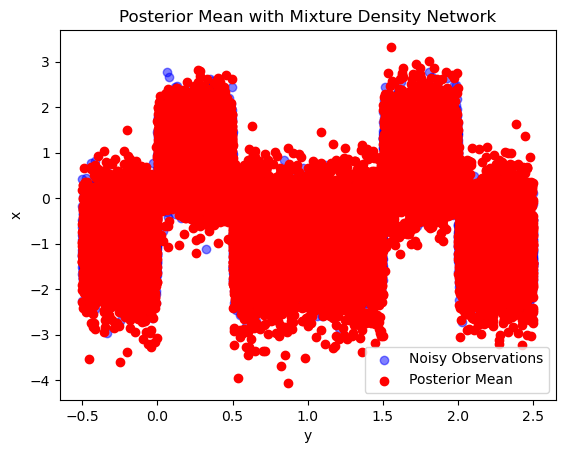

In [5]:
# Plot the posterior mean
plt.scatter(y, xtrue, c='blue', label='Noisy Observations', alpha=0.5)
plt.scatter(y, est_post, color='red', label='Posterior Mean')
plt.title('Posterior Mean with Mixture Density Network')
plt.xlabel('y')
plt.ylabel('x')
plt.legend()
plt.show()


In [6]:
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *
from ash import *

res_ash = ash( x, np.full(x .shape[0],1))
mse_noisy = np.mean((xtrue - x)**2)
mse_ash = np.mean (( res_ash.post_mean - xtrue)**2)

mse_true = np.mean((est_post - xtrue)**2)
print(f"\nMean Squared Error:")
print(f"MSE (Est Post vs Y Noisy): {mse_noisy:.4f}")
print(f"MSE (Ash Post vs Y True): {mse_ash:.4f}")
print(f"MSE (Est Post vs Y True): {mse_true:.4f}")



Mean Squared Error:
MSE (Est Post vs Y Noisy): 1.0099
MSE (Ash Post vs Y True): 0.5893
MSE (Est Post vs Y True): 0.4233


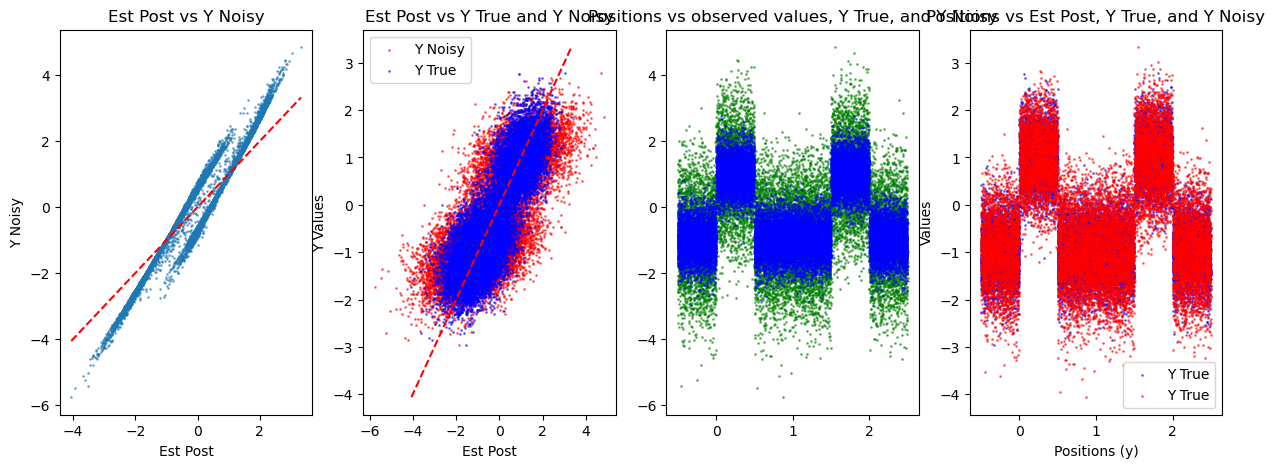

In [7]:
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post, x, alpha=0.5, s=1)
plt.title('Est Post vs Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Noisy')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(x, xtrue, alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post, xtrue, alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Values')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3)
#plt.scatter(y, y_n_np, alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(y, x, alpha=0.5, s=1, label='Y True', color='green')
plt.scatter(y, xtrue, alpha=0.5, s=1, label='Y True', color='blue')
#plt.scatter(y, x, alpha=0.5, s=1, label='Y True', color='green')
plt.title('Positions vs observed values, Y True, and Y Noisy')
plt.subplot(1,4,4)
plt.scatter(y, xtrue, alpha=0.5, s=1, label='Y True', color='blue')

plt.scatter(y, est_post, alpha=0.5, s=1, label='Y True', color='red')
plt.title('Positions vs Est Post, Y True, and Y Noisy')
plt.xlabel('Positions (y)')
plt.ylabel('Values')
plt.legend()